# Kaggle Competition: Predicting Survival on the Titanic

The RMS Titanic sank in the early hours of 15-Apr-1912 taking 1502 lives with it. It remains one of the most haunting tragedies of modern history and a cautionary tale against sidestepping important safety countermeasures. 

While luck certainly played a role in gaining a life boat seat, it seems some passengers had a better chance than others. 

In this notebook I'll experiment with different machine learning models to predict whether or not a passenger survived based on their sex, age, class, fare and other factors. After identifying the best model, I'll submit my predictions to the Kaggle competition to compare with the test data. 

The dataset and competition information is available [here](https://www.kaggle.com/c/titanic).

# Explore the Data

In [1]:
# load packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visuals
import seaborn as sns # visuals

# import train and test csvs
train = pd.read_csv("/Users/katestone/Desktop/CSV files/titanic_train.csv")
holdout = pd.read_csv("/Users/katestone/Desktop/CSV files/titanic_test.csv")

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The train dataset contains 12 columns detailing the following:
- PassengerId: Passenger ID number;
- Survived: Survived or not;
- Pclass: Which class the passenger was in 1st to 3rd;
- Name: Full name of the passenger with title;
- Sex: Sex of the passenger;
- Age: Age in years;
- SibSp: Number of siblings and/or spouses onboard;
- Parch: Number of parents and/children on board;
- Ticket: Ticket number;
- Fare: Passenger fare;
- Cabin: Cabin number;
- Embarked: Port of Embarkation.

The holdout dataset contains the same columns except for the survived column.

It seems like a few of the columns contain missing values. Lets take a closer look.

In [4]:
# identify missing values
print(train[train.columns].isna().sum())
print("\n")
print(holdout[holdout.columns].isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Most columns don't contain any missing values. I'll deal with the columns containing only 1 to 2 missing values by filling them in with the mean or most common value. The others I'll deal with shortly.

In [5]:
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Fare"] = holdout["Fare"].fillna(holdout["Fare"].mean())

print(train["Embarked"].isna().sum())
print(holdout["Fare"].isna().sum())

0
0


# Pre-process the Data

One of the first steps in the machine learning workflow is to pre-process the data and make it more useful for machine learning. Lets start by taking a look at the continuous variable columns: Age and Fare. 

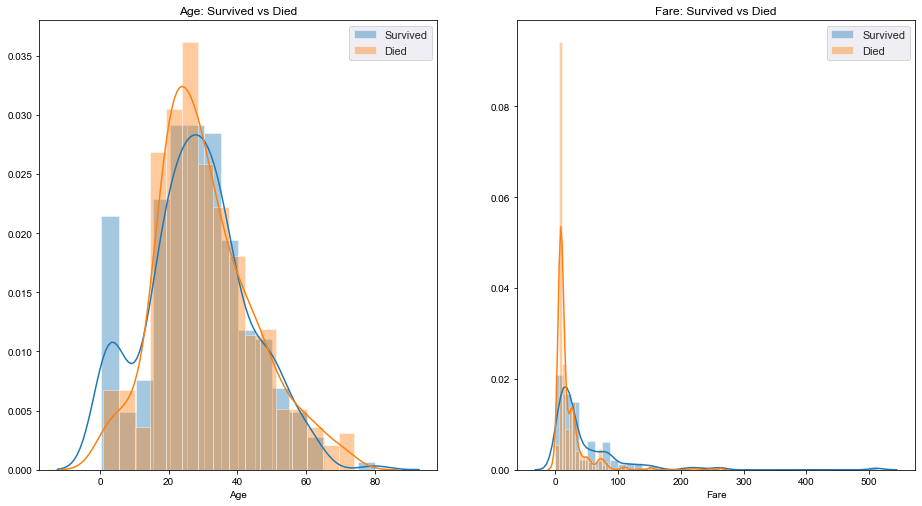

In [6]:
# Plot survival rates for age and fare variables
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, sharex=False)
fig.set_size_inches(15.7, 8.27)
sns.set(style="darkgrid")
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
sns.distplot(survived["Age"].dropna(), ax=ax1)
sns.distplot(died["Age"].dropna(), ax=ax1)
sns.distplot(survived["Fare"].dropna(), ax=ax2)
sns.distplot(died["Fare"].dropna(), ax=ax2)
ax1.legend(['Survived','Died'])
ax2.legend(['Survived','Died'])
ax1.title.set_text('Age: Survived vs Died')
ax2.title.set_text('Fare: Survived vs Died')
ax1.set_xlabel('Age')
ax2.set_xlabel('Fare')
plt.show()

At the moment the relationship between age, fare and survived is not easy to see. Some ages and fare ranges do seem to have higher rates of survival though. 

Lets separate these continuous variables into ranges to make them more useful to the machine learning model. I'll do this by creating some functions.

In [7]:
# Function to process age values
def process_age(df):
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

# Function to process fare values
def process_fare(df):
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

Other columns that could use some pre-processing to make them more useful are the cabin and name variables.

In [8]:
print(train["Cabin"].head())
print("\n")
print(train["Name"].head())

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object


0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


At the moment these columns don't seem to be that useful for making predictions as they are full of unique values. Maybe creating two new categorical variables from the first letter of the cabin column and the title from each passenger name will enhance the predictive power of the model.

In [9]:
# Function to process title values
def process_titles(df):
    titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

# Function to process cabin values
def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    return df

SibSp and Parch, which decribe the number of siblings/spouse and parents/children respectively, could also be interesting to explore. Lets create a new variable called "Family_size" by combining these two variables together and see how it relates to survival. 

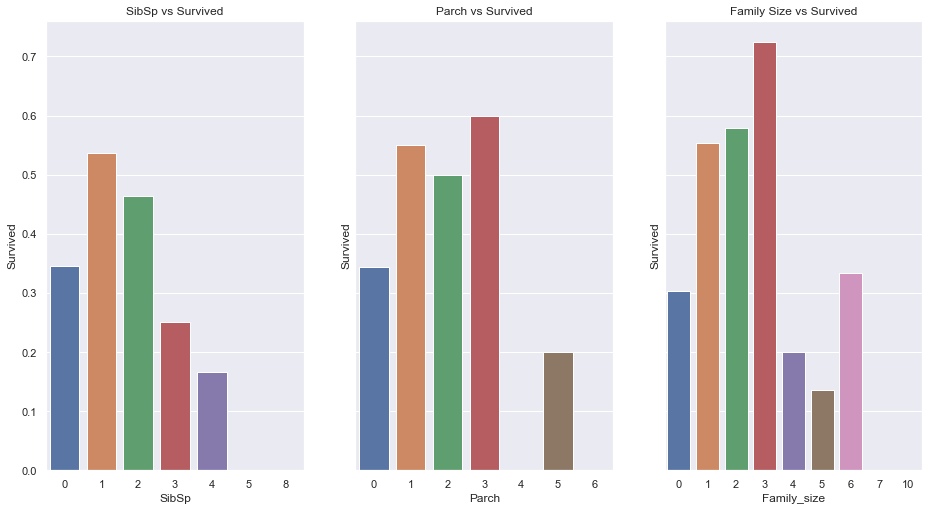

In [10]:
# combine SibSp and Parch to form total family size
train["Family_size"] = train[["SibSp", "Parch"]].sum(axis=1)
holdout["Family_size"] = holdout[["SibSp", "Parch"]].sum(axis=1)

# Plot survival rates for variables
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, sharex=False)
fig.set_size_inches(15.7, 8.27)
sns.set(style="darkgrid")
SibSp_pivot = train.pivot_table(index="SibSp",values="Survived")
sns.barplot(x = SibSp_pivot.index, y = SibSp_pivot.Survived, ax=ax1)
Parch_pivot = train.pivot_table(index="Parch",values="Survived")
sns.barplot(x = Parch_pivot.index, y = Parch_pivot.Survived, ax=ax2)
Family_size_pivot = train.pivot_table(index="Family_size",values="Survived")
sns.barplot(x = Family_size_pivot.index, y = Family_size_pivot.Survived, ax=ax3)
ax1.title.set_text('SibSp vs Survived')
ax2.title.set_text('Parch vs Survived')
ax3.title.set_text('Family Size vs Survived')
plt.show()

We can see that people with 1 to 3 family members on board seem to have a higher chance of survival than those that don't have any family members onboard. It might be useful to create a new variable that identifies whether someone is travelling alone or not. Lets create a function to do this.

In [11]:
# create function to process family_size column
def process_family(df):
    df["isalone"] = 0
    df.loc[(df["Family_size"] == 0),"isalone"] = 1
    return df

A number of columns are categorical and are no use to the model in their current form. Lets create a function to transform these variables into dummy columns which we can use. 

In [12]:
# Function to create dummy columns
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Now that we've created a number of functions to transform the data lets combine them into a master function which will return a dataset we can begin to work with.

In [13]:
# Create master function which combines all of the above
def process_df(df):
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = process_family(df)
    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    return df

# Apply function to dfs
train = process_df(train)
holdout = process_df(holdout)

# Feature Selection

The next step is to select the best features to input into the model. To do this I'll use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination. 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# create function to select features
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1, n_estimators=100)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_size', 'isalone', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male']



# Model Selection and Tuning

Now that the best features have been identified we can begin testing different models and different hyperparameters. Lets create a function to do this for us. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(max_iter=1000),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1, n_estimators=100),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        }
    ]
    
    for model in models:
        print(model["name"])
        grid = GridSearchCV(estimator = model["estimator"], 
                            param_grid = model["hyperparameters"],
                           cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
Best Score: 0.8215488215488216
Best Parameters: {'solver': 'newton-cg'}

RandomForestClassifier
Best Score: 0.8417508417508418
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}

KNeighborsClassifier
Best Score: 0.7822671156004489
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}



/Users/katestone/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Of the all the models tested, RandomForestClassifier returned the highest accuracy at over 84%. Lets apply this model to the holdout data and submit the predictions to Kaggle.

# Submit to Kaggle

In [18]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[1]["best_model"]
save_submission_file(best_rf_model,cols)

The submission yielded an accuracy score of 78%, placing 8,878th out of 24,458 entries. This is a reasonably good starting off point. Steps I'll take to improve my score further include:
- Engineering more features;
- Optimise feature selection further;
- Testing more models. 